In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable

from Optimizer_AdLaLa import AdLaLa

In [2]:
# Shared hyperparameters

input_size = 784
hidden_size = 250
num_classes = 10
num_epochs = 20
batch_size = 100

In [3]:
# Downloading MNIST data

train_data = dsets.MNIST(
    root = './data',
    train = True,
    transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ]),
    download = True)

test_data = dsets.MNIST(
    root = './data',
    train = False,
    transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ]),
    download = True)

In [4]:
# Loading the data

train_gen = torch.utils.data.DataLoader(dataset = train_data,
                                        batch_size = batch_size,
                                        shuffle = True)

test_gen = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size,
                                      shuffle = False)

In [5]:
# Defining model class

class SingleHiddenLayerPerceptron(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super().__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_size, num_classes)

  def forward(self,x):
    out = self.fc1(x)
    out = self.relu(out)
    out = self.fc2(out)
    return out

In [6]:
def eval_accuracy(network, test_generator):
    correct = 0
    total = 0
    for images, labels in test_generator:
        images = Variable(images.view(-1,28*28)).cuda()
        labels = labels.cuda()

        output = network(images)
        _, predicted = torch.max(output,1)
        correct += (predicted == labels).sum()
        total += labels.size(0)
    return correct.item() / total

# Adam

In [7]:
net = SingleHiddenLayerPerceptron(input_size, hidden_size, num_classes)
if torch.cuda.is_available():
  net.cuda()
  print('cuda on')

cuda on


In [8]:
# default hp for Adam

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters())

In [9]:
epoch_train_loss = []
train_loss = []
accuracy_history = [eval_accuracy(net, test_gen)]

for epoch in range(num_epochs):
    acc_loss = 0
    for i, (images,labels) in enumerate(train_gen):
        images = Variable(images.view(-1,28*28)).cuda()
        labels = Variable(labels).cuda()

        optimizer.zero_grad()
        outputs = net(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        this_loss = loss.item()
        train_loss.append(this_loss)
        acc_loss += this_loss
        if (i+1) % 100 == 0:
            print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                    %(epoch+1, num_epochs, i+1, len(train_data)//batch_size, this_loss))
    epoch_loss = acc_loss / (len(train_data)//batch_size)
    epoch_train_loss.append(epoch_loss)
    this_accuracy = eval_accuracy(net, test_gen)
    accuracy_history.append(this_accuracy)
    print(f'Epoch {epoch+1} loss={epoch_loss:.4f}; accuracy={this_accuracy:.3f}')

Epoch [1/20], Step [100/600], Loss: 0.2317
Epoch [1/20], Step [200/600], Loss: 0.1210
Epoch [1/20], Step [300/600], Loss: 0.0997
Epoch [1/20], Step [400/600], Loss: 0.1503
Epoch [1/20], Step [500/600], Loss: 0.2605
Epoch [1/20], Step [600/600], Loss: 0.2543
Epoch 1 loss=0.2515; accuracy=0.960
Epoch [2/20], Step [100/600], Loss: 0.0660
Epoch [2/20], Step [200/600], Loss: 0.0477
Epoch [2/20], Step [300/600], Loss: 0.1098
Epoch [2/20], Step [400/600], Loss: 0.0543
Epoch [2/20], Step [500/600], Loss: 0.0860
Epoch [2/20], Step [600/600], Loss: 0.1093
Epoch 2 loss=0.1025; accuracy=0.970
Epoch [3/20], Step [100/600], Loss: 0.0302
Epoch [3/20], Step [200/600], Loss: 0.0331
Epoch [3/20], Step [300/600], Loss: 0.0305
Epoch [3/20], Step [400/600], Loss: 0.1018
Epoch [3/20], Step [500/600], Loss: 0.0305
Epoch [3/20], Step [600/600], Loss: 0.1668
Epoch 3 loss=0.0675; accuracy=0.977
Epoch [4/20], Step [100/600], Loss: 0.0433
Epoch [4/20], Step [200/600], Loss: 0.0268
Epoch [4/20], Step [300/600], Lo

In [10]:
print(
    f'The final accuracy is: {eval_accuracy(net, test_gen):%}'
)

The final accuracy is: 97.970000%


# AdLaLa

In [7]:
net = SingleHiddenLayerPerceptron(input_size, hidden_size, num_classes)
if torch.cuda.is_available():
  net.cuda()
  print('cuda on')

cuda on


In [8]:
lr = 0.1     # Step size / learning rate
tau1 = 1e-4     # Temperature for AdLa part (this is the first part of the partitioned system)
tau2 = 5e-5    # Temperature for Langevin (2nd part)
gamma = 0.15    # Friction parameter for Langevin part
sigma = 0.05    # Driving noise amplitude for Adaptive Langevin
eps = 0.05     # Coupling coefficient for Adaptive Langevin
cgamma = np.exp(-lr*gamma)
dgamma = np.sqrt(1-np.exp(-2*lr*gamma))*np.sqrt(tau2)

loss_function = nn.CrossEntropyLoss()
optimizer = AdLaLa(net.parameters(), lr=lr, eps=eps, sigA=sigma, T1=tau1, cgamma=cgamma, dgamma=dgamma)

In [9]:
epoch_train_loss_adlala = []
train_loss_adlala = []
accuracy_history_adlala = [eval_accuracy(net, test_gen)]

for epoch in range(num_epochs):
    acc_loss = 0
    for i, (images,labels) in enumerate(train_gen):
        images = Variable(images.view(-1,28*28)).cuda()
        labels = Variable(labels).cuda()
        outputs = net(images)

        if i == 0 and epoch == 0:
            output = net(images)
            loss = loss_function(output, labels)

            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.stepMom()

        optimizer.stepAOA()
        output = net(images)
        loss = loss_function(output, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.stepB()

        this_loss = loss.item()
        train_loss_adlala.append(this_loss)
        acc_loss += this_loss
        if (i+1) % 100 == 0:
            print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                    %(epoch+1, num_epochs, i+1, len(train_data)//batch_size, this_loss))
    epoch_loss = acc_loss / (len(train_data)//batch_size)
    epoch_train_loss_adlala.append(epoch_loss)
    this_accuracy = eval_accuracy(net, test_gen)
    accuracy_history_adlala.append(this_accuracy)
    print(f'Epoch {epoch+1} loss={epoch_loss:.4f}; accuracy={this_accuracy:.3f}')

Epoch [1/20], Step [100/600], Loss: 0.3451
Epoch [1/20], Step [200/600], Loss: 0.2581
Epoch [1/20], Step [300/600], Loss: 0.3129
Epoch [1/20], Step [400/600], Loss: 0.3102
Epoch [1/20], Step [500/600], Loss: 0.1756
Epoch [1/20], Step [600/600], Loss: 0.2332
Epoch 1 loss=0.3941; accuracy=0.925
Epoch [2/20], Step [100/600], Loss: 0.2449
Epoch [2/20], Step [200/600], Loss: 0.2163
Epoch [2/20], Step [300/600], Loss: 0.2750
Epoch [2/20], Step [400/600], Loss: 0.1431
Epoch [2/20], Step [500/600], Loss: 0.2604
Epoch [2/20], Step [600/600], Loss: 0.1965
Epoch 2 loss=0.2192; accuracy=0.944
Epoch [3/20], Step [100/600], Loss: 0.1765
Epoch [3/20], Step [200/600], Loss: 0.1565
Epoch [3/20], Step [300/600], Loss: 0.1289
Epoch [3/20], Step [400/600], Loss: 0.2571
Epoch [3/20], Step [500/600], Loss: 0.1644
Epoch [3/20], Step [600/600], Loss: 0.0964
Epoch 3 loss=0.1726; accuracy=0.951
Epoch [4/20], Step [100/600], Loss: 0.2334
Epoch [4/20], Step [200/600], Loss: 0.2320
Epoch [4/20], Step [300/600], Lo

In [10]:
print(
    f'The final accuracy is: {eval_accuracy(net, test_gen):%}'
)

The final accuracy is: 96.620000%


Text(0.5, 1.0, 'train loss')

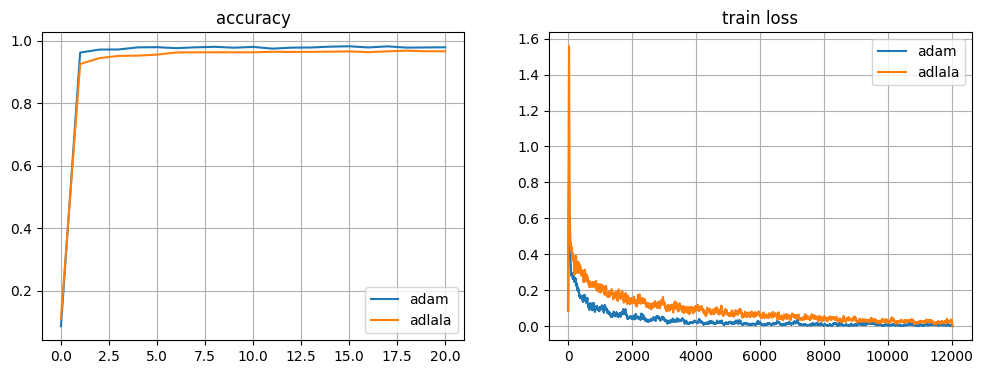

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(accuracy_history, label='adam')
axs[0].plot(accuracy_history_adlala, label='adlala')
axs[0].legend()
axs[0].grid()
axs[0].set_title('accuracy')
if False:
    # average loss per epoch
    loss_to_plot = epoch_train_loss
    loss_to_plot_adlala = epoch_train_loss_adlala
else:
    # sliding average of the loss per step
    loss_to_plot = np.convolve(train_loss, [1/27]*27)
    loss_to_plot_adlala = np.convolve(train_loss_adlala, [1/27]*27)
axs[1].plot(loss_to_plot, label='adam')
axs[1].plot(loss_to_plot_adlala, label='adlala')
axs[1].legend()
axs[1].grid()
axs[1].set_title('train loss')


In [11]:
from PIL import Image
import pathlib

all_images = []

for path in pathlib.Path('mnist-custom-data').glob('*.jpeg'):
    img = Image.open(path)

    img = img.resize((28, 28))
    img = np.array(img).astype(float)
    img = np.mean(img, axis=2)
    img /= 255.
    img = 1. - img
    all_images.append(img)

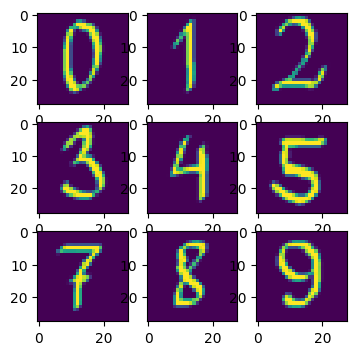

In [12]:
fig, axs = plt.subplots(3, 3, figsize=(4, 4))
for i, el in enumerate(all_images):
    axs[i // 3, i % 3].imshow(el)

In [13]:
all_images_numpy = np.array(all_images)
all_images_numpy = (all_images_numpy - 0.1307)/0.3081

In [16]:
img_pytorch = torch.Tensor(all_images_numpy.reshape(-1, 28*28)).cuda()
res = net(img_pytorch)
_, pred = torch.max(res, 1)
print(pred)

tensor([0, 1, 2, 3, 4, 5, 7, 8, 3], device='cuda:0')
